In [7]:
import numpy as np
import scipy.linalg as sc
import matplotlib.pyplot as plt

from MRPy import MRPy

### Introdução

Amortecedor de massa ativo

### Estrutura

O modelo reduzido utilizado no estudo foi o de um prédio com dois graus de liberdade (movimento horizontal). Para 


In [18]:
## steel rod 80x20x0.5mm
L  = 0.15
EI = 2.05e11*(0.02*0.0005**3)/12
k  = 12*EI/L/L/L

# Stiffness coefficients in N/m
K = np.array ([[ 2*k, -2*k], 
               [-2*k,  4*k]])


# Lumped mass matrix in kg
m1=0.4
m2=0.4

M = np.array([ [m1,  0,], 
               [0,  m2,]])

print (K)
print (M)

[[ 303.7037037  -303.7037037 ]
 [-303.7037037   607.40740741]]
[[0.4 0. ]
 [0.  0.4]]


Cálculo das frequências e modos de vibrações

In [19]:
# Uses scipy to solve the standard eigenvalue problem
w2, Phi = sc.eig(K, M)

# Ensure ascending order of eigenvalues
iw  = w2.argsort()
w2  = w2[iw]
Phi = Phi[:,iw]

# Eigenvalues to vibration frequencies
wk  = np.sqrt(np.real(w2)) 
fk  = wk/2/np.pi

print('First vibration mode:  {0:5.2f}Hz, [{1:6.3f} {2:6.3f}]'.format(fk[0], *Phi[:,0]))
print('Second vibration mode: {0:5.2f}Hz, [{1:6.3f} {2:6.3f}]'.format(fk[1], *Phi[:,1]))

print (Phi)

First vibration mode:   2.71Hz, [ 0.851  0.526]
Second vibration mode:  7.10Hz, [-0.526  0.851]
[[ 0.85065081 -0.52573111]
 [ 0.52573111  0.85065081]]


In [10]:
Mk = np.diag(np.dot(Phi.T, np.dot(M, Phi)))

print('First mode modal mass is:  {0:7.2f}kg'.format(Mk[0]))
print('Second mode modal mass is: {0:7.2f}kg'.format(Mk[1]))

First mode modal mass is:     0.40kg
Second mode modal mass is:    0.40kg


1 ª frequencia natural = 2.71Hz 

2 ª frequencia natural = 7.10Hz 



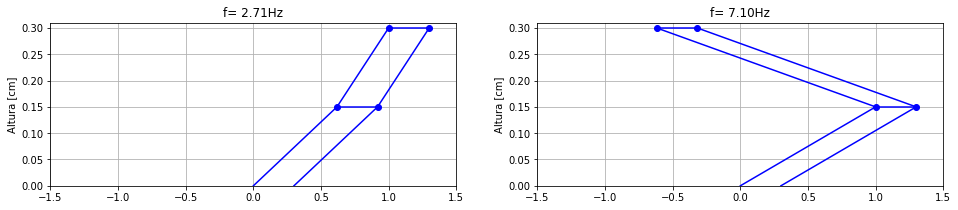

In [22]:
## Imprimir as 3 primeiras frequências
for k in range(2):
    print(k+1, "ª frequencia natural = {0:3.2f}Hz".format(fk[k]),"\n")
## Plotagem dos 3 primeiros modos de vibração da estrutura
plt.figure(1, figsize=(16,3))
x = np.linspace(0,2*L,3)

for k in range(2):
    pk = np.zeros(3)
    pk[1:] = Phi[::-1,k]
    pk /=np.max(np.abs(pk))
    plt.subplot(1,2,k+1)
    
    ## Linhas Horizontais
    for n in range(2):
        o = np.linspace(pk[n+1],pk[n+1]+2*L,2)
        y1 = np.ones(2)*n*L+L
        plt.plot(o, y1, 'b')
    
    ## Pontos
    plt.plot(pk[1:],x[1:],'bo')
    plt.plot(pk[1:]+2*L, x[1:], 'bo')
    
    ## Linhas Verticais
    plt.plot(pk,x,'b')
    plt.plot(pk+2*L, x,'b')

    plt.xlim(-1.5, 1.5); plt.ylabel("Altura [cm]");
    plt.ylim( 0.0, 2*L+.01);
    plt.title('f= {0:3.2f}Hz'.format(fk[k]));
    plt.grid(True)

O primeiro andar é excitado por uma força de impacto de intensidade F0 e frequência fm.

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


R.M.S. displacement of system mass: 40.714m
R.M.S. displacement of damper:      25.159m


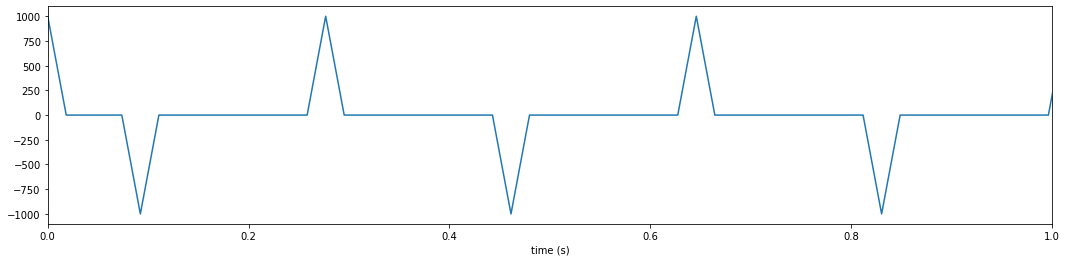

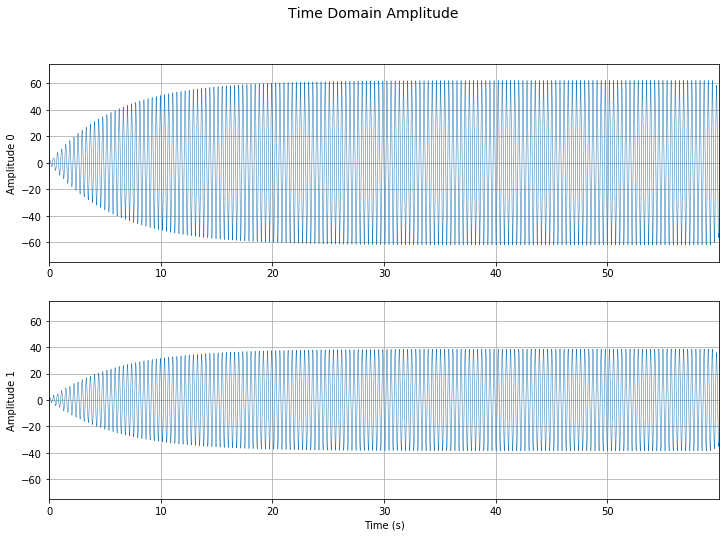

In [33]:
# Excitation properties
F0 =  1000          # Intensity            
fm=fk[0]               # Frequency
Tm=1/fm
#Time discretization

Td =  60
n = 10
N  =  60/(Tm/2/n)
fs =  N/Td
zt=0.01


t  =  np.linspace(0, Td, N+1)        # time domain
F1 = np.zeros(t.shape)

t1=60/N
n=int((Tm/4)/t1)
F1[0]=1*F0
for i in range (int((N/(4*n)-1))):
    F1[3*n+i*4*n]=1*F0
    F1[n+i*4*n]=-1*F0    
    
F  = [F1, np.zeros(t.shape)]     # loading vector

# Modal force as MRPy object
Fk =  MRPy(np.dot(Phi.T, F), fs=fs)

# Normalize by modal masses:
for k in range(2):
    Fk[k,:] /= Mk[k]
    

    
    
    
plt.figure(2, figsize=(18, 4), clear=True)
plt.plot(t,F[0])    
plt.xlim(0, 1);   plt.xlabel('time (s)') 
#plt.ylim(-2, 2.0);   plt.ylabel('force (N)')
    
uk =  Fk.sdof_Duhamel(fk, zt)           # solve by Duhamel
ut =  MRPy(np.dot(Phi, uk), fs=uk.fs)   # back from modal space


ut.plot_time();

print('R.M.S. displacement of system mass: {0:6.3f}m'.format(ut[0].std()))
print('R.M.S. displacement of damper:      {0:6.3f}m'.format(ut[1].std())) 

### Programação no Raspberry Pi
A seguir, temos o scrcipt do programa utilizado para excitar o primeiro grau de liberdade. Os equipamentos empregados foram:  
1 - Raspberry Pi Zero  
2 - Pêndulo  
3 - Motor de passo